### 1D Burger Equation NFTM Simulator using a CNN as the controller.

The Burger equation in 1-dimension is given by:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$


* We want to build a NFTM with a CNN-based update rule for simulating the 1D Burgers equation.

* NFTM architecture:
    * Neural Controller $C$ $\to$ CNN in this case.

    * Continuous memory field (spatial domain) $f_t$: **updates are restricted to neighbour points**.

    * Movable read/write heads that perform **local updates** $h_t$: operate over local regions/patches of this field.

* NFTM architecture for PDEs:
    * The continuous **field** models the spatial domain, a grid representing the solutions $u(x,t)$.

    * The **controller** reads a local patch (neighbourhood) at each time step, computes an update (using CNN), and writes the new value back (updates values in the field). Responsible of updating values + controlling position of read/write heads.

    * At each time step $t$ the CNN controller reads a region, for example: $[u_{i-1}, u_i, u_{i+1}]$ (in 1D) as its input.

    * The CNN uses this input to compute updates by applying a CNN kernel and then writes the updated values back to the same region.

#### Import necessary packages 

In [1]:
# Set environment variables before importing libraries that may initialize OpenMP
# This reduces the chance of multiple OpenMP runtimes (libiomp5md) being initialized
import os
# Unsafe but practical workaround for Windows OpenMP conflicts; keeps the kernel alive.
# If you'd prefer not to use this, see notes below for safer long-term fixes.
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
import math
from torch.utils.data import Dataset, DataLoader

# Debug: show a couple of env vars (optional)
print("KMP_DUPLICATE_LIB_OK=", os.environ.get("KMP_DUPLICATE_LIB_OK"),
      "OMP_NUM_THREADS=", os.environ.get("OMP_NUM_THREADS"),
      "MKL_NUM_THREADS=", os.environ.get("MKL_NUM_THREADS"))


KMP_DUPLICATE_LIB_OK= TRUE OMP_NUM_THREADS= 1 MKL_NUM_THREADS= 1


#### Load Training Data

* The following class combines the 1D Burgers datasets corresponding to different values of viscosity into one unified dataset.

* Associates each solution trajectory ($[u(x_0,t), u(x_1,t),...,u(x_{N-1},t)]$) with the correct viscosity value.

In [2]:
class BurgersViscosityDataset(Dataset):
    def __init__(self, datasets, viscosities):
        # datasets: list of Tensors, each of shape (num_examples, T, N) for different viscosities
        # viscosities: list or Tensor of corresponding viscosity scalars (floats)
        self.data = []
        self.nu = []

        for data, nu in zip(datasets, viscosities):
            time_instances = data.shape[0]
            self.data.append(data)
            # Create tensor of shape (time_instances, 1) with viscosity nu repeated
            self.nu.append(torch.full((time_instances, 1), nu, dtype=torch.float32))
        
        self.data = torch.cat(self.data, dim=0)  # concatenate all examples
        self.nu = torch.cat(self.nu, dim=0)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Return (initial_field, full_trajectory, viscosity)
        full_trajectory = self.data[idx]          # shape (T, N)
        # print(full_trajectory)
        initial_field = full_trajectory[0, :]     # shape (batch_size, N)
        nu = self.nu[idx]                         # shape (1,)
        return initial_field, full_trajectory, nu


In [3]:
# Functions to load datasets produced by `burger.py` (handles both 'U' and 'u' keys)
def load_burgers_npz_file(file_path):
    data = np.load(str(file_path), allow_pickle=True)
    # prefer 'U' then 'u'
    if 'U' in data.files:
        U = data['U']
    elif 'u' in data.files:
        U = data['u']
    else:
        # pick the first array-like entry that's not metadata
        chosen = None
        for k in data.files:
            if k not in ('x','t','dx','dt','nu','speed','tag'):
                chosen = data[k]
                break
        if chosen is None:
            chosen = data[data.files[0]]
        U = chosen
    U = np.asarray(U)
    # Ensure 2D: (T, N)
    if U.ndim == 1:
        U = U[np.newaxis, :]
    elif U.ndim > 2:
        # try to squeeze leading singleton dims
        U = U.reshape(U.shape[0], -1)
    return torch.tensor(U, dtype=torch.float32)  # shape (T, N)


def _align_array_to_shape(arr, target_T, target_N):
    """Align a (T, N) array to (target_T, target_N) by truncation or padding.
    - Time dimension (axis=0): if shorter, repeat last frame; if longer, truncate.
    - Spatial dimension (axis=1): if shorter, pad by edge values; if longer, truncate.
    """
    arr = np.asarray(arr)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    T, N = arr.shape

    # Time alignment
    if T < target_T:
        # repeat last row to pad
        last = arr[-1:]
        pads = np.repeat(last, target_T - T, axis=0)
        arr = np.concatenate([arr, pads], axis=0)
    elif T > target_T:
        arr = arr[:target_T, :]

    # Space alignment
    if arr.shape[1] < target_N:
        pad_width = target_N - arr.shape[1]
        # pad equally both sides if possible, prefer pad on right if odd
        left = pad_width // 2
        right = pad_width - left
        arr = np.pad(arr, ((0, 0), (left, right)), mode='edge')
    elif arr.shape[1] > target_N:
        # center-crop or left-crop? choose center crop
        excess = arr.shape[1] - target_N
        left = excess // 2
        arr = arr[:, left:left+target_N]

    return arr


def collect_generated_burgers(root_dir, align=True):
    """Scan `root_dir` (or its subfolders) for .npz files created by `burger.py`.
    Groups files by their saved `nu` value (if present) and returns:
      - datasets: list of tensors, each with shape (num_examples, T, N)
      - viscosities: list of floats, one per dataset group

    If files within a group have different shapes, they will be aligned (pad/truncate)
    when `align=True`. If align=False and shapes differ, a ValueError is raised.
    """
    from pathlib import Path
    root_dir = Path(root_dir)
    npz_files = sorted([p for p in root_dir.glob('**/*.npz')])
    if len(npz_files) == 0:
        raise FileNotFoundError(f"No .npz files found in {root_dir}")

    groups = {}
    shapes_per_group = {}
    for p in npz_files:
        data = np.load(str(p), allow_pickle=True)
        if 'nu' in data.files:
            nu = float(data['nu'])
        else:
            # fallback default if nu not present
            nu = 0.1
        # prefer 'U' key (saved by burger.py)
        if 'U' in data.files:
            U = np.asarray(data['U'])
        elif 'u' in data.files:
            U = np.asarray(data['u'])
        else:
            # pick first non-meta
            chosen = None
            for k in data.files:
                if k not in ('x','t','dx','dt','nu','speed','tag'):
                    chosen = data[k]
                    break
            if chosen is None:
                chosen = data[data.files[0]]
            U = np.asarray(chosen)

        # ensure 2D
        if U.ndim == 1:
            U = U[np.newaxis, :]
        elif U.ndim > 2:
            U = U.reshape(U.shape[0], -1)

        groups.setdefault(nu, []).append(U)
        shapes_per_group.setdefault(nu, set()).add(U.shape)

    datasets = []
    viscosities = []
    for nu, arrs in groups.items():
        shapes = shapes_per_group[nu]
        if len(shapes) == 1:
            # all same shape -> stack directly
            arrs_np = np.stack(arrs, axis=0)
        else:
            if not align:
                raise ValueError(f"Input arrays for nu={nu} do not have the same shape: {shapes}")
            # align to common shape: choose max T and max N across arrs
            Ts = [a.shape[0] for a in arrs]
            Ns = [a.shape[1] for a in arrs]
            target_T = max(Ts)
            target_N = max(Ns)
            aligned = [_align_array_to_shape(a, target_T, target_N) for a in arrs]
            arrs_np = np.stack(aligned, axis=0)

        datasets.append(torch.tensor(arrs_np, dtype=torch.float32))
        viscosities.append(float(nu))

    return datasets, viscosities


In [4]:
current_dir = Path(os.getcwd()) # get current directory

# Locate the generated dataset folder (search the workspace for the folder name)
gen_dirs = list(current_dir.glob('**/generated_1d_burgers'))
if gen_dirs:
    data_root = gen_dirs[0]
else:
    # fallback: expect generated_1d_burgers next to this notebook
    data_root = Path.cwd() / 'generated_1d_burgers'
    if not data_root.exists():
        raise FileNotFoundError("Could not find 'generated_1d_burgers' in the workspace. Place the dataset under that folder or adjust the path.")

print(f"Using dataset root: {data_root}")

# Use train split if present, otherwise use the folder itself
train_dir = data_root / 'train'
if train_dir.exists():
    use_dir = train_dir
else:
    use_dir = data_root

# Collect datasets grouped by viscosity
datasets, viscosities = collect_generated_burgers(use_dir)
print(f"Found {sum(d.shape[0] for d in datasets)} examples across {len(datasets)} viscosity groups: {viscosities}")

# Build combined dataset and dataloader
combined_dataset = BurgersViscosityDataset(datasets, viscosities)
dataloader = DataLoader(combined_dataset, batch_size=4, shuffle=True)

print("Combined dataset shape:", combined_dataset.data.shape)


Using dataset root: c:\Dev\CentralSupelec\BDRP\NFTM\NFTM_for_Physic\generated_1d_burgers
Found 40 examples across 1 viscosity groups: [0.10000000149011612]
Combined dataset shape: torch.Size([40, 256, 128])


#### Extract local regions from field: create patches

* For each spatial position $i$, we want to extract the slide $[u_{i-r},...,u_i,...,u_{i+r}]$.

* $r$ is the patch radius (how many neighbours you consider from left and right side).

* We then pass this patch/region to the CNN controller to perform updates.

* Patch size: $2r +1$ (no. of points you take from spatial field).

* We create a 3D tensor `patches` storing the patch (neighbour points) for each spatial location in the field.

In [ ]:
# Choose value of the patch radius r:
r = 1 

# Patch size: 
patch_size = 2 * r + 1

# Need to extend the field at the edges (add padding) so all patches have a full size: 2r + 1.
# Create a padded tensor by adding r points on both ends of the tensor, new size of tensor: N + 2r 
padded_field = nn.functional.pad(initial_field, (r, r), mode='replicate')  # shape (1, N + 2r)

# For each spatial point, we extract the local neighbours (patch) of size 2r + 1:
patches = padded_field.unfold(dimension = 1, size = patch_size, step = 1) # shape (1, N, 2r + 1)

# print(patches.shape)
batch_size = patches.shape[0]
patch_size = patches.shape[2]

#### CNN controller

* Construct CNN that acts as the controller to process each patch.

* Typical architecture: input layer of patch size, one or two convolutional layers with kernel sizes equal or smaller than the patch size, nonlinear activations (ReLU or tanh), and output layer producing updated values for the center point in the patch.

* The CNN processes patches independently across the field.


In [ ]:
# CNN controller definition:
class CNNController(nn.Module):
    def __init__(self, patch_size):
        super(CNNController, self).__init__()
        # Maintenant L canaux en entrée (les L derniers champs empilés)
        self.conv1 = nn.Conv1d(in_channels=HISTORY_LEN, out_channels=8, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.pool = nn.MaxPool1d(kernel_size=2, stride=1)

        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.spatial_reduce = nn.AdaptiveAvgPool1d(output_size=1)
        self.output_layer = nn.Conv1d(in_channels=8, out_channels=1, kernel_size=1)

    def forward(self, x):
        # x: (batch_size*N, HISTORY_LEN, patch_size)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.spatial_reduce(x)
        x = self.output_layer(x)  # (B*N, 1, 1)
        return x

    
# Create CNN controller for our NFTM:
cnn_controller = CNNController(patch_size) # r = 1

#### Read/Write head

* The controller reads patches, computes local updates, and writes these updates back into the corresponding local regions of the field.

* Reading: extract patches (local neighbourhoods) centered at each spatial position. These patches have shape `(batch_size, N, patch_size)`.

* Need to **reshape** patches to `(batch_size * N, 1, patch_size)`, to go as **input** into the CNN controller. This enables the CNN to process all patches in parallel as separate inputs in a batch.

* We treat each patch (local neighbours) as a separate 1D sample with 1 channel + length equal to patch_size.

* CNN **outputs** a **scalar value** per patch, with shape: `(batch_size * N, 1, 1)`.

* Need to **reshape** back to the field shape: `(batch_size,  N)`.

* Writing: updating the field.


In [ ]:
import torch.nn.functional as F

def build_patches_from_sequence(fields_seq, r, patch_size):
    """
    fields_seq: (B, L, N)  -> L = HISTORY_LEN dernières étapes
    Retourne: (B*N, L, patch_size) pour alimenter le CNN
    """
    B, L, N = fields_seq.shape
    patches_list = []
    for l in range(L):
        field_l = fields_seq[:, l, :]                 # (B, N)
        padded_l = F.pad(field_l, (r, r), mode='replicate')
        patches_l = padded_l.unfold(1, patch_size, 1) # (B, N, patch_size)
        patches_list.append(patches_l)
    patches_seq = torch.stack(patches_list, dim=2)    # (B, N, L, patch_size)
    return patches_seq.reshape(B * N, L, patch_size)  # (B*N, L, patch_size)


In [ ]:
# suppose que T >= HISTORY_LEN+1
fields_seq = full_trajectory[:, :HISTORY_LEN, :]   # (B, L, N)
patches_input = build_patches_from_sequence(fields_seq, r, patch_size)  # (B*N, L, patch)
patches_updates = cnn_controller(patches_input)    # (B*N, 1, 1)
patches_updates = patches_updates.reshape(batch_size, N)

# Reshape outputs:
patches_updates = patches_updates.reshape(batch_size, N) # batch_size = 4

# Writing: update the spatial field with new values.
initial_field = initial_field + patches_updates


#### Loss Function

* A common choice for the cost function is the MSE: $$L_{MNE} = \frac{1}{N} \sum_{i = 1}^{N} \sum_{t = 1}^{T} (u_{i,t} - \hat u_{i,t})^2$$

* N = no. spatial points at each time snapshot.

* T = no. of time snapshots where solution is considered.

* $\hat u_{i,t}$ = NFTM's predicted velocity at spatial point $i$ and time $t$.

* $u_{i,t}$ = truth velocity at spatial point $i$ and time $t$.

* The error between predicted values and truth solutions from your training data at different time steps.

In [13]:
mse_loss = nn.MSELoss() # LOSS FUNCTION

#### Optimizer

* We backpropagate the loss and update the CNN controller's weights using an optimizer.

    * Clear the gradients before backpropagation: `optimizer.zero_grad()`.

    * Compute gradients of the loss with respect to model parameters (backpropagation): `loss.backward()`.

    * Update the model parameters using the computed gradients: `optimizer.step()`.

* We can use the Adam optimizer among others.

In [14]:
optimizer = torch.optim.Adam(cnn_controller.parameters(), lr = 0.001) # OPTIMIZER

#### Training Loop

Epoch 1/20, Cost: 187.828151
Epoch 2/20, Cost: 162.237368
Epoch 3/20, Cost: 132.919562
Epoch 4/20, Cost: 100.120311
Epoch 5/20, Cost: 80.460433
Epoch 6/20, Cost: 58.432353
Epoch 7/20, Cost: 30.824640
Epoch 8/20, Cost: 10.315657
Epoch 9/20, Cost: 1.551574
Epoch 10/20, Cost: 1.468270
Epoch 11/20, Cost: 1.092752
Epoch 12/20, Cost: 0.671805
Epoch 13/20, Cost: 0.653072
Epoch 14/20, Cost: 0.563784
Epoch 15/20, Cost: 0.511556
Epoch 16/20, Cost: 0.482598
Epoch 17/20, Cost: 0.440708
Epoch 18/20, Cost: 0.417588
Epoch 19/20, Cost: 0.394733
Epoch 20/20, Cost: 0.375067


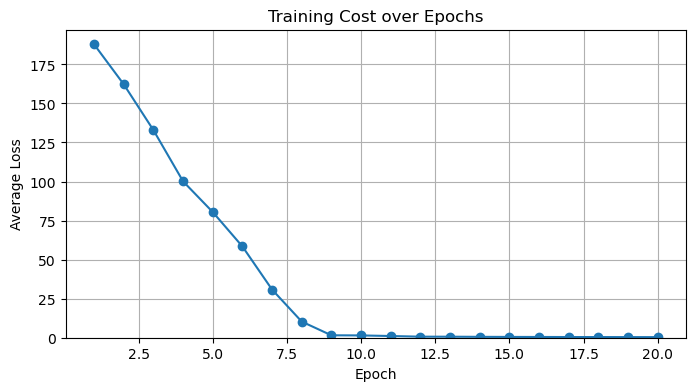

In [15]:
num_epochs = 20
epoch_losses = []

for epoch in range(num_epochs):
    total_loss = 0.0
    for initial_field, full_trajectory, nu in dataloader:
        optimizer.zero_grad()

        batch_size, N = initial_field.shape
        T = full_trajectory.shape[1]
        loss_over_time = 0.0

        # on entraîne de t = L à T-1
        for t in range(HISTORY_LEN, T):
            # séquence d'entrée: (B, L, N)
            fields_seq = full_trajectory[:, t-HISTORY_LEN:t, :]  # sans le pas courant
            # construire les patches pour chaque des L champs
            patches_list = []
            for l in range(HISTORY_LEN):
                field_l = fields_seq[:, l, :]                       # (B, N)
                padded_l = torch.nn.functional.pad(field_l, (r, r), mode='replicate')
                patches_l = padded_l.unfold(1, patch_size, 1)       # (B, N, patch)
                patches_list.append(patches_l)

            # empile en canaux temporels: (B, N, L, patch)
            patches_seq = torch.stack(patches_list, dim=2)
            # reshape pour le CNN: (B*N, L, patch)
            patches_input = patches_seq.reshape(batch_size * N, HISTORY_LEN, patch_size)

            # prédiction du champ u_t
            outputs = cnn_controller(patches_input).reshape(batch_size, N)  # (B, N)

            targets_t = full_trajectory[:, t, :].to(outputs.device)         # (B, N)
            loss = mse_loss(outputs, targets_t)
            loss_over_time = loss_over_time + loss

        loss_over_time.backward()
        optimizer.step()

        total_loss += loss_over_time.item()

    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Cost: {avg_loss:.6f}")


plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Cost over Epochs')
plt.ylim(bottom=0)
plt.grid(True)
plt.show()


In [16]:
def visualize_heatmap(field_pred, field_true, sample_idx=0):
    print(f"Visualizing solutions for viscosity = {nu[sample_idx].item():.4f}")

    pred = field_pred[sample_idx].cpu().detach().numpy()  # shape (T, N)
    true = field_true[sample_idx].cpu().detach().numpy()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(true, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='u(x,t) Ground Truth')
    plt.xlabel('Spatial position x')
    plt.ylabel('Time step t')
    plt.title('True Trajectories')

    plt.subplot(1, 2, 2)
    plt.imshow(pred, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='u(x,t) Predicted')
    plt.xlabel('Spatial position x')
    plt.ylabel('Time step t')
    plt.title('Predicted Trajectories')

    plt.tight_layout()
    plt.show()



Visualizing solutions for viscosity = 0.1000


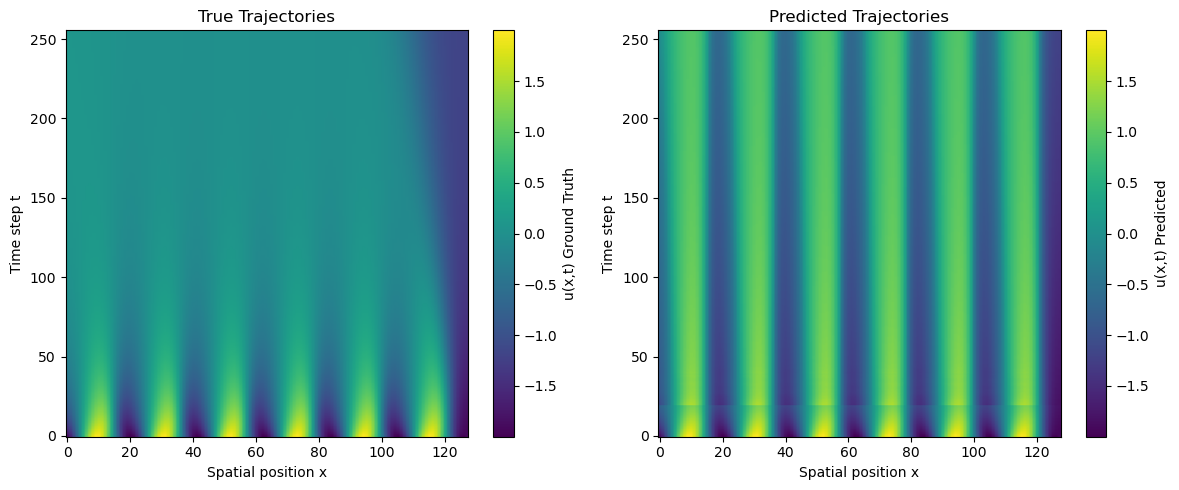

CNNController(
  (conv1): Conv1d(20, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (act1): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (act2): ReLU()
  (spatial_reduce): AdaptiveAvgPool1d(output_size=1)
  (output_layer): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
)

In [17]:
# --- Final evaluation and visualization ---
cnn_controller.eval()
with torch.no_grad():
    for initial_field, full_trajectory, nu in dataloader:
        batch_size, N = initial_field.shape
        T = full_trajectory.shape[1]
        device = initial_field.device

        predictions = torch.zeros((batch_size, T, N), device=device)

        # warm-up: copier les L premières vraies étapes
        predictions[:, :HISTORY_LEN, :] = full_trajectory[:, :HISTORY_LEN, :].to(device)

        # on maintient une fenêtre (B, L, N)
        window = predictions[:, :HISTORY_LEN, :].clone()

        for t in range(HISTORY_LEN, T):
            patches_list = []
            for l in range(HISTORY_LEN):
                field_l = window[:, l, :]                             # (B, N)
                padded_l = torch.nn.functional.pad(field_l, (r, r), mode='replicate')
                patches_l = padded_l.unfold(1, patch_size, 1)         # (B, N, patch)
                patches_list.append(patches_l)

            patches_seq = torch.stack(patches_list, dim=2)            # (B, N, L, patch)
            patches_input = patches_seq.reshape(batch_size * N, HISTORY_LEN, patch_size)

            pred_next = cnn_controller(patches_input).reshape(batch_size, N)  # (B, N)
            predictions[:, t, :] = pred_next

            # décale la fenêtre temporelle: enlève le plus ancien, ajoute la nouvelle prédiction
            window = torch.cat([window[:, 1:, :], pred_next.unsqueeze(1)], dim=1)

        # visualisation (inchangée)
        targets_batch = full_trajectory.to(device)
        visualize_heatmap(predictions, targets_batch, sample_idx=0)
        break

cnn_controller.train()



Summary of the Architecture:

* Input: 1D spatial field representing $u(x,t)$.

* Patch extraction: Sliding local neighborhoods of radius $r$.

* Controller: CNN processing each local patch.

* Update: Local field value updates returned by CNN.

* Iteration: Time-stepping loop applying CNN update repeatedly.

* Output: Predicted evolution of $u(x,t)$ over time.

This setup lets you build an end-to-end differentiable NFTM that learns local update rules via convolutional kernels, naturally capturing the physics of the 1D Burgers equation with your training data.